**Imports**

In [1]:

import os
import pandas as pd

import numpy as np

import pyplotterlib.standard.plotters as ppl

import project_path


**Configuration Variables**

In [2]:
TRAIN_PATH = os.path.join("..","..","raw_data","train.csv")
OIL_PATH = os.path.join("..","..","raw_data","oil.csv")

#
_currKwargs = {"constrainedLayout":True, "figHeightPerRow":4, "figWidthPerCol":6, "nColsGrid":4}
RECT_MULTI_PLOTTER = ppl.RectMultiPlotter(**_currKwargs)

**Import data files**

In [3]:
RAW_DF = pd.read_csv(TRAIN_PATH)

**Look at mean sales across all stores for a given date/product family**

In [4]:
def _getStandardLinePlotterForUseFrame(inpFrame, colName, rollWindow=7):
    assert inpFrame.index.names == ["store_nbr", "family", "date"]
    
    #Get the plot data [Instantaneous]
    useFrame = inpFrame.unstack("family").unstack("store_nbr")["sales"].dropna()
    dateValsInst = np.array(useFrame.index, dtype="datetime64")
    yValsInst = useFrame[colName].unstack().groupby("date").mean().to_numpy()
    instPlotData = np.column_stack([np.array(dateValsInst,dtype=object),
                                    np.array(yValsInst,dtype=object)])
    
    #Get the plot data [rolling average]
    rollMeanData = useFrame[colName].unstack().groupby("date").mean().rolling(window=rollWindow).mean().dropna()
    rollMeanDates = np.array(rollMeanData.index, dtype='datetime64')
    rollMeanPlotData = np.column_stack( [np.array(rollMeanDates,dtype=object),
                                         np.array(rollMeanData.to_numpy(),dtype=object)]  )

    #Create the plotter
    outPlotter = _getTemplPlotter().createFactory(plotData=[instPlotData, rollMeanPlotData], titleStr=colName)
    return outPlotter
    
def _getTemplPlotter():
    _currKwargs = {"fontSizeDefault":12, "gridLinesShowY":True, "lineMarkerStyles":["x","None"],
                   "lineStyles":["None","solid"], "tickLabelRotationX":70,
                   "xLabelStr":"Date", "yLabelStr":"Mean Sales (averaged over stores)"
                  }
    return ppl.LinePlotter(**_currKwargs)
    

In [5]:
%%prun
#         3498512 function calls (3129098 primitive calls) in 17.833 seconds
useFrame = RAW_DF[1:].set_index(["store_nbr","family","date"]).sort_index()
useCols = useFrame.index.unique(level="family")

allPlotters = [_getStandardLinePlotterForUseFrame(useFrame, x) for x in useCols]

Note: The orange line is moving average sales for a 7-day period

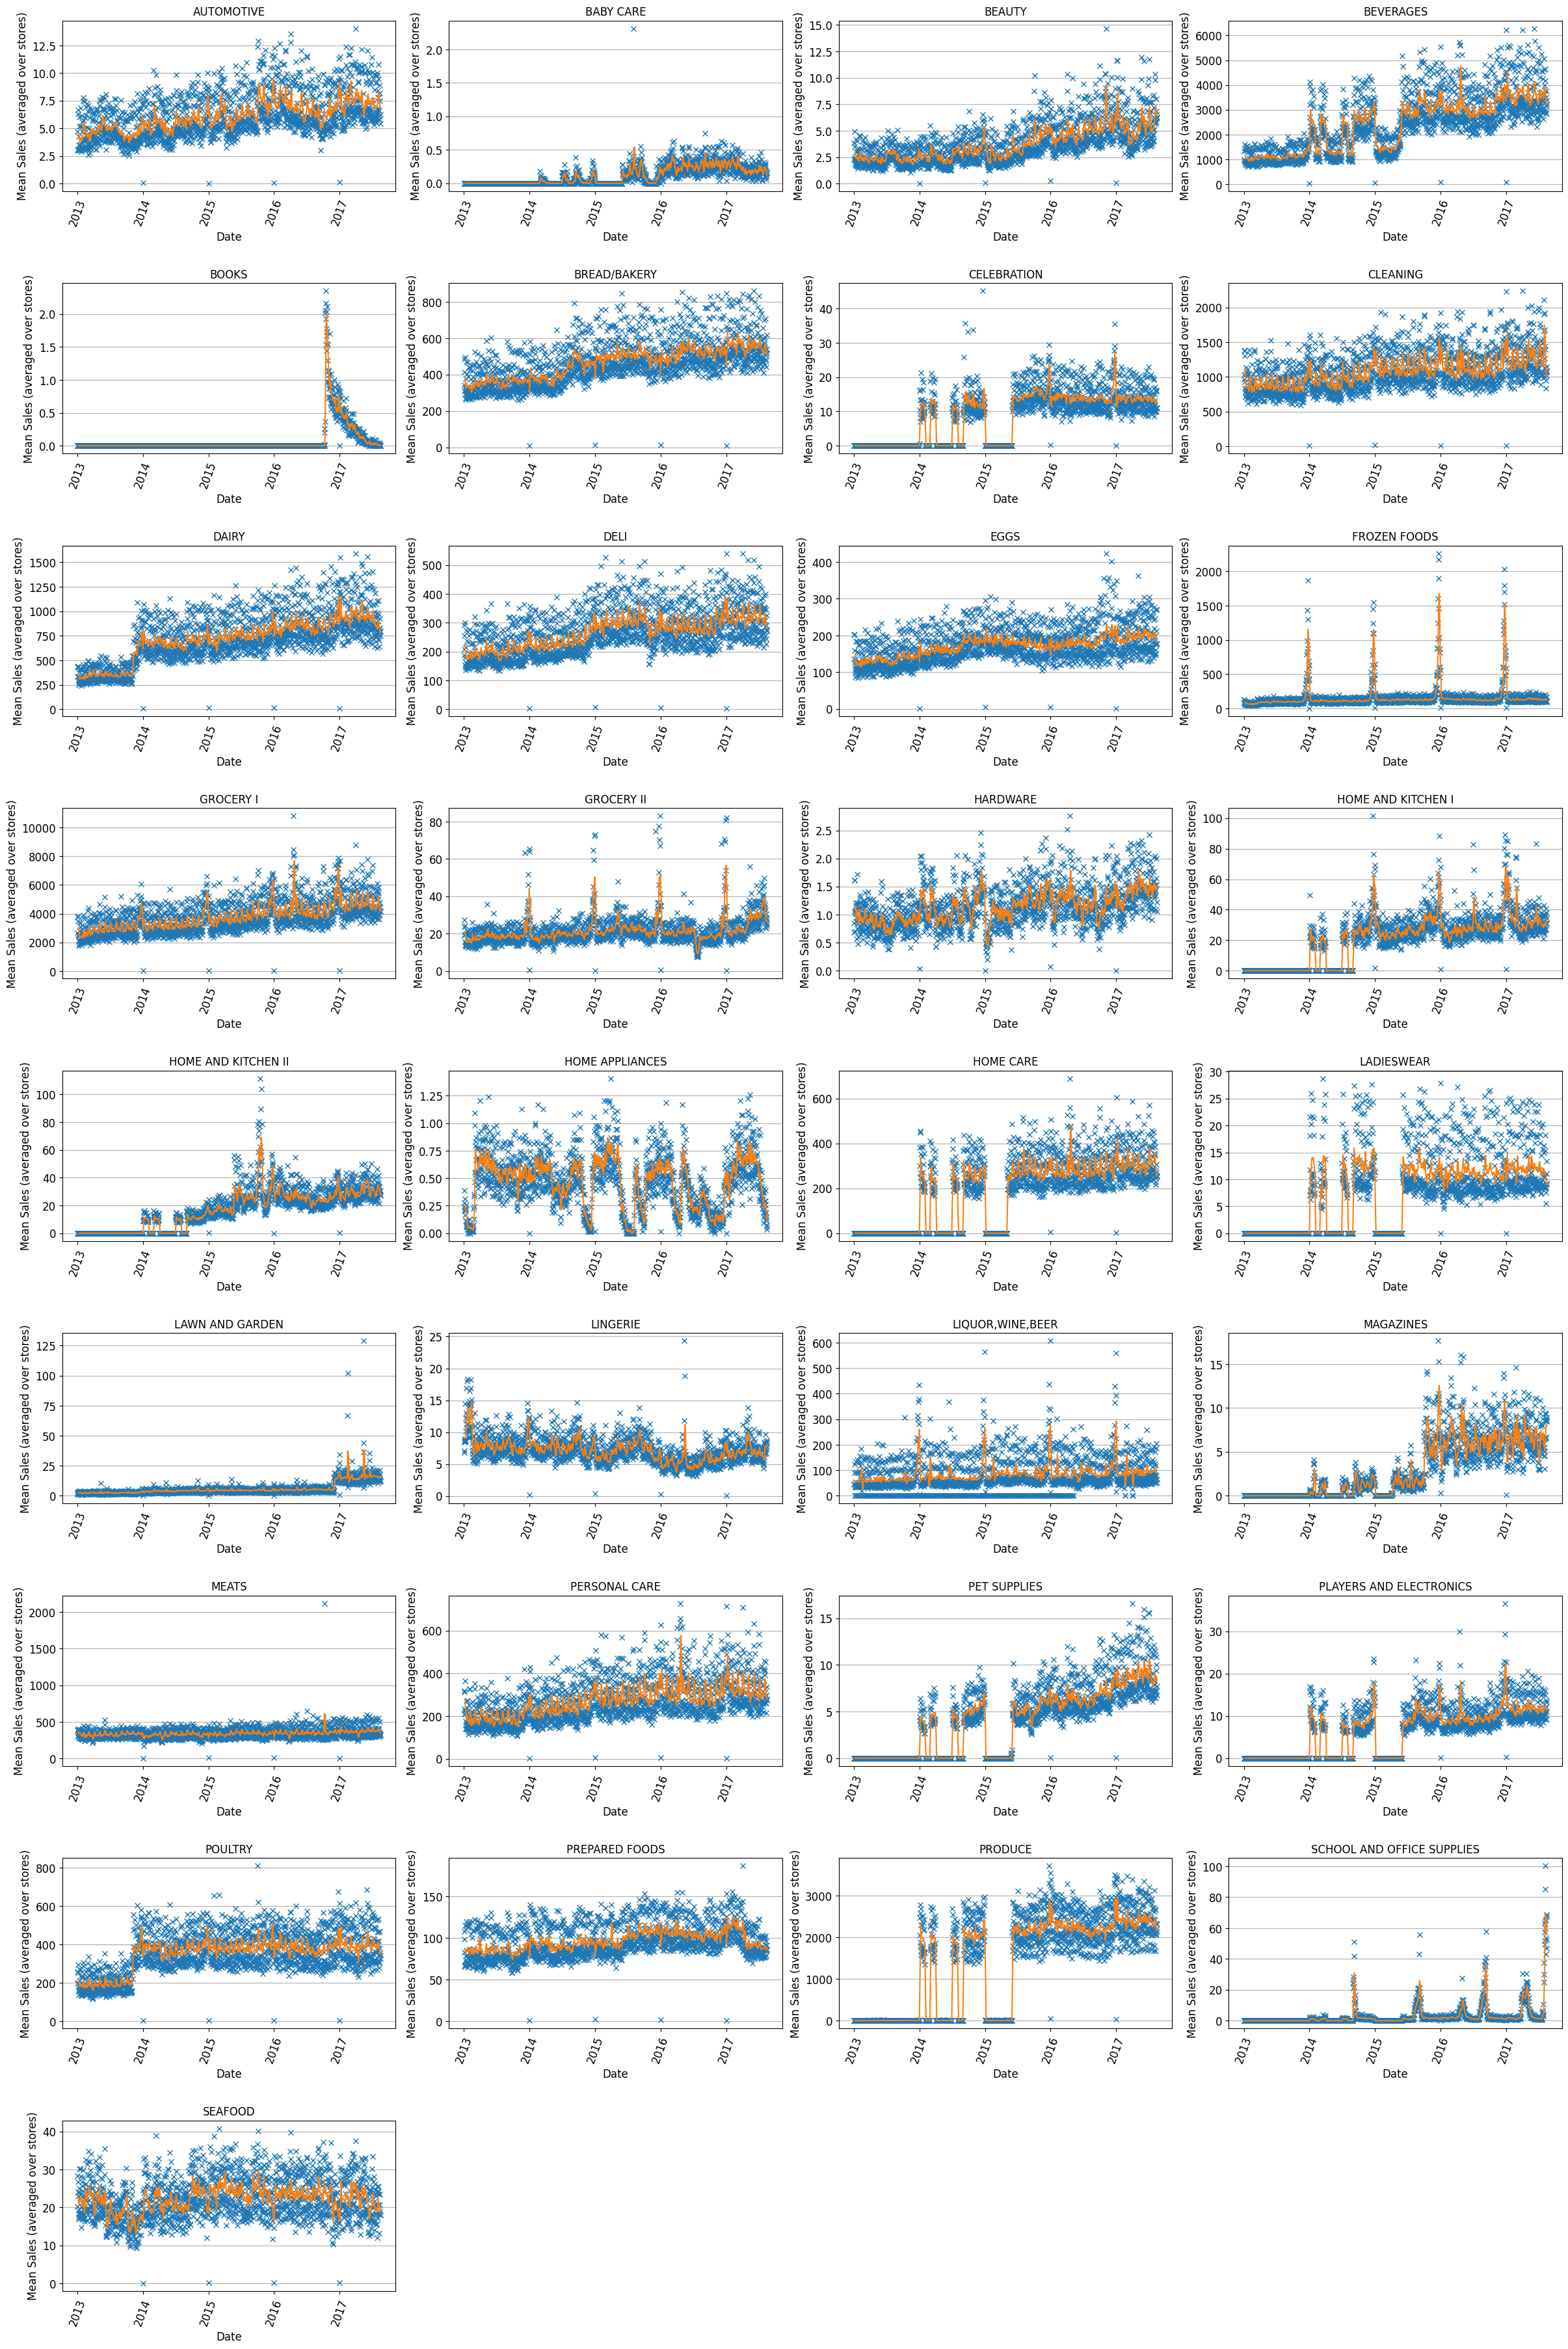

In [6]:
_unused = RECT_MULTI_PLOTTER.createPlot(plotters=allPlotters,spacingVert=0.1)

**Look at oil prices over the period**

In [7]:
OIL_DATA  = pd.read_csv(OIL_PATH)
OIL_DATA.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
#Re-read (since i modify it and its quick)
OIL_DATA  = pd.read_csv(OIL_PATH)


#Fill in any missing dates (with knowledge that we KNOW the start and end date are there)
OIL_DATA = OIL_DATA.set_index("date")
OIL_DATA.index = pd.DatetimeIndex(OIL_DATA.index)
idxRange = pd.date_range(OIL_DATA.index.min(),OIL_DATA.index.max())
OIL_DATA = OIL_DATA.reindex(idxRange)
OIL_DATA.index.name = "date"

#Add a moving average
OIL_DATA["rolling"] = OIL_DATA["dcoilwtico"].rolling(window=7, min_periods=0).mean()
OIL_DATA = OIL_DATA.reset_index()



In [9]:
_currKwargs = {"dataLabels":["Instant", "Rolling (7-day)"],
              "plotData": [ OIL_DATA[["date","dcoilwtico"]].to_numpy(), OIL_DATA[["date","rolling"]].to_numpy() ],
               "lineMarkerStyles":["x","None"],
              "lineStyles":['None',"-"],
               "showLegend":True,
               "xLabelStr":"Date", "yLabelStr":"Oil Price (Units Unknown)"}
oilPlotter = ppl.LinePlotter(**_currKwargs)

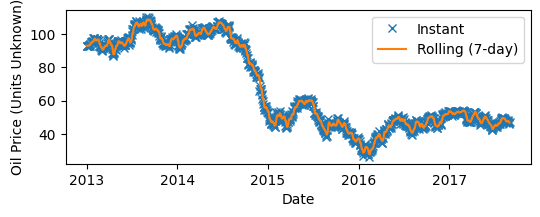

In [10]:
_unused = oilPlotter.createPlot( figSizeOnCreation=(6,2)  )